## Data Drift

Data drift occurs when a machine model's performance declines or is different on unseen data compared to its training data due distribution changes in the data over time. In this notebook, we explore and visualize data drift on a simple XGBoost model, that predicts credit card acceptance based on an applicant's age, credit score, years of education, and years in employment. This demo is a Jupyter notebook counterpart for a prexisting demo, [Data Drift](https://github.com/trustyai-explainability/odh-trustyai-demos.git). Please refer to its `README.md` for more details, as well as how to perform the following steps in ODH.

### Prerequisites
Follow the instructions within the [Installation](https://github.com/trustyai-explainability/odh-trustyai-demos/tree/main/1-Installation) section. Additionally, follow the instructions in the `Deploy Model` sectionin the [Data Drift](https://github.com/trustyai-explainability/odh-trustyai-demos/blob/main/3-DataDrift/README.md) demo. Before proceeding, check that you have the following:
- ODH installation
- A TrustyAI Operator
- A model-namespace project containing an instance of the TrustyAI Service
- A model storage container
- A Seldon MLServer serving runtime
- The delpoyed credit model


### Imports

In [1]:
import os
import subprocess
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from trustyai.utils.api.api import TrustyAIApi
from trustyai.utils.extras.metrics_service import TrustyAIMetricsService

### Clone the Data Drift Repository
For the purposes of recreating the data drift demo in a Jupyter `notebook, we will be reusing the data in that repository. 

In [2]:
!git clone https://github.com/trustyai-explainability/odh-trustyai-demos.git
!cd odh-trustyai-demos/3-DataDrift

In [3]:
os.chdir("odh-trustyai-demos/3-DataDrift/")
os.getcwd()

'/Users/christinaxu/Documents/trustyai-explainability-python/odh-trustyai-demos/3-DataDrift'

### Initialize Metrics Service
In order to use the metrics service, we first have to initialize it using our OpenShift login token and model namespace.

In [4]:
TOKEN = os.environ.get("TOKEN", "None")
trustyService = TrustyAIMetricsService(
    token = TOKEN,
    namespace="model-namespace",
    verify=False
)

### Upload Model Training Data To TrustyAI

In [5]:
trustyService.upload_payload_data(
    json_file="data/training_data.json"
)

Data sucessfully uploaded to TrustyAI service


### Label Data Fields

In [6]:
name_mapping = {
    "modelId": "gaussian-credit-model",
    "inputMapping":
      {
        "credit_inputs-0": "Age",
        "credit_inputs-1": "Credit Score",
        "credit_inputs-2": "Years of Education",
        "credit_inputs-3": "Years of Employment"
      },
    "outputMapping": {
      "predict-0": "Acceptance Probability"
    }
}

trustyService.label_data_fields(payload=name_mapping)

credit_inputs-0 -> Age
credit_inputs-1 -> Credit Score
credit_inputs-2 -> Years of Education
credit_inputs-3 -> Years of Employment


'Feature and output name mapping successfully applied.'

### Examining TrustyAI's Model Metadata

In [7]:
trustyService.get_model_metadata()

[{'metrics': {'scheduledMetadata': {'metricCounts': {}}},
  'data': {'inputSchema': {'items': {'credit_inputs-2': {'type': 'DOUBLE',
      'name': 'credit_inputs-2',
      'values': None,
      'index': 2},
     'credit_inputs-3': {'type': 'DOUBLE',
      'name': 'credit_inputs-3',
      'values': None,
      'index': 3},
     'credit_inputs-0': {'type': 'DOUBLE',
      'name': 'credit_inputs-0',
      'values': None,
      'index': 0},
     'credit_inputs-1': {'type': 'DOUBLE',
      'name': 'credit_inputs-1',
      'values': None,
      'index': 1}},
    'remapCount': 2,
    'nameMapping': {'credit_inputs-0': 'Age',
     'credit_inputs-1': 'Credit Score',
     'credit_inputs-2': 'Years of Education',
     'credit_inputs-3': 'Years of Employment'},
    'nameMappedItems': {'Years of Education': {'type': 'DOUBLE',
      'name': 'credit_inputs-2',
      'values': None,
      'index': 2},
     'Age': {'type': 'DOUBLE',
      'name': 'credit_inputs-0',
      'values': None,
      'index': 

### Register Drift Monitoring

In [8]:
drift_monitoring = {
    "modelId": "gaussian-credit-model",
    "referenceTag": "TRAINING"
}
trustyService.get_metric_request(
    payload=drift_monitoring, 
    metric="drift/meanshift", reoccuring=True
)

'{"requestId":"709174f5-a3f4-4ae9-8f7e-a56b708836ff","timestamp":"2024-03-06T14:23:17.740+00:00"}'

### Check the Metrics
Let's get the meanshift values for the training data we just uploaded to the TrustyAI service for the past 5 minutes.

In [11]:
train_df = trustyService.get_metric_data( 
    metric="trustyai_meanshift", 
    time_interval="[5m]"
)
display(train_df.head())

,timestamp,Age,Credit Score,Years of Education,Years of Employment
0,2024-03-06 09:23:18,1.0,1.0,1.0,1.0
1,2024-03-06 09:23:22,1.0,1.0,1.0,1.0
2,2024-03-06 09:23:26,1.0,1.0,1.0,1.0
3,2024-03-06 09:23:30,1.0,1.0,1.0,1.0
4,2024-03-06 09:23:34,1.0,1.0,1.0,1.0


Let's also visualize the meanshift in a plot similar to the one displayed in ODH `Observe -> Metrics` tab. We will define a helper function so that we can use it again for the unseen data.

In [12]:
def plot_meanshift(df):
    """
    :param df: A pandas DataFrame returned by the TrustyAIMetricsService().get_metric_request 
               function with columns corresponding to the timestamp and name of the metric
    returns a scatterplot with the timestamp on the x-axis and the specific metric on the y-axis
    """
    plt.figure(figsize=(12,5))
    for col in df.columns[1:]:
        plt.plot(
            df["timestamp"],
            df[col]
        )
    plt.xlabel("timestamp")
    plt.ylabel("meanshift")
    plt.xticks(rotation=45)
    plt.legend(df.columns[1:])
    plt.tight_layout()
    plt.show()

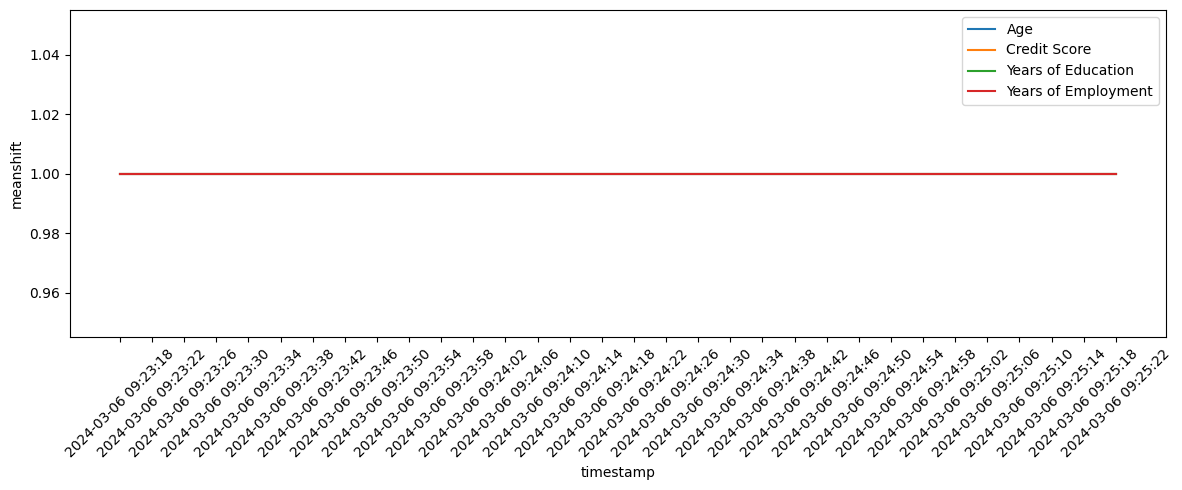

In [13]:
plot_meanshift(train_df)

### Collect "Real-World" Inferences

In [14]:
model_name = "gaussian-credit-model"
model_route = TrustyAIApi().get_service_route(
    name=model_name, 
    namespace=trustyService.namespace
)

for batch in list(range(0, 596, 5)):
    trustyService.upload_data_to_model(
        model_route=f"{model_route}/v2/models/gaussian-credit-model",
        json_file=f"data/data_batches/{batch}.json"
    )

### Observe Drift
Let's check if our model is behaving differently on the unseen data. 

In [16]:
test_df = trustyService.get_metric_data( 
    metric="trustyai_meanshift", 
    time_interval="[5m]"
    )
display(test_df.head())

,timestamp,Age,Credit Score,Years of Education,Years of Employment
0,2024-03-06 09:23:18,1.0,1.0,1.0,1.0
1,2024-03-06 09:23:22,1.0,1.0,1.0,1.0
2,2024-03-06 09:23:26,1.0,1.0,1.0,1.0
3,2024-03-06 09:23:30,1.0,1.0,1.0,1.0
4,2024-03-06 09:23:34,1.0,1.0,1.0,1.0


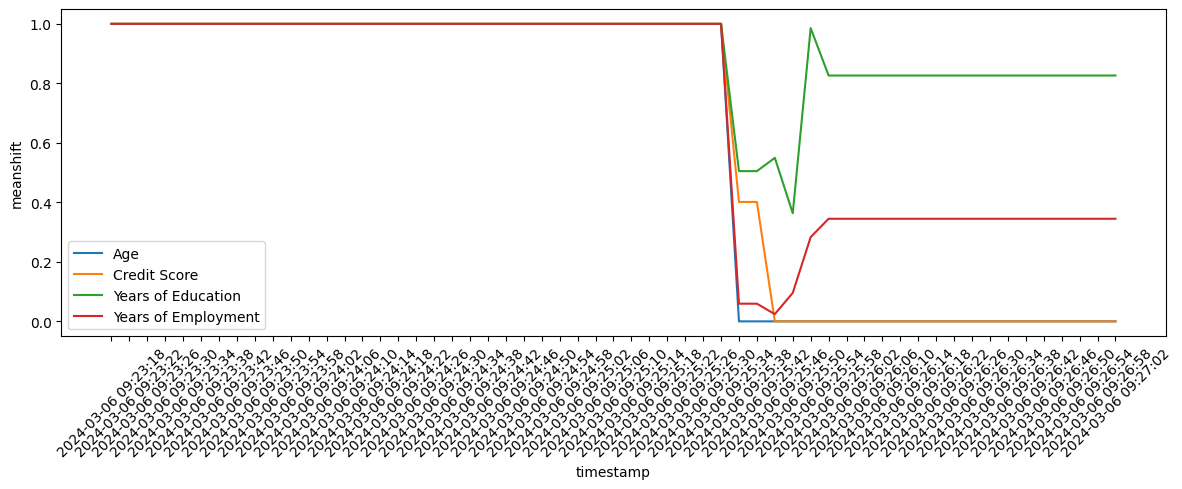

In [17]:
plot_meanshift(test_df)

As observed, the meanshift values for each of the features have changed drastically from the training to test data, dropping below 1.0. In particular, `Age` and `Credit Score` are significantly different according to a p-value of 0.05. Thus, it is clear that our model suffers from data drift.